Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
## Import Dataset :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
!unzip gdrive/MyDrive/melanoma_dataset/CNN_assignment.zip

Archive:  gdrive/MyDrive/melanoma_dataset/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  i

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [10]:
for images, labels in train_ds.take(1):
  print(images.shape)
  print(labels.shape)
  print(images[0].shape)

(32, 180, 180, 3)
(32,)
(180, 180, 3)


In [11]:
im_list=[]
for i in class_names:
  b = "Skin cancer ISIC The International Skin Imaging Collaboration/Train/" + i +'/*.jpg'
  for filename in glob(b):
    im= Image.open(filename)
    im_list.append(im)
    break
im_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F148AB78A60>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1424BAA6D0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1424BAA610>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1424BAA760>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1424BAA670>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1424BAA790>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1424BAA820>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1424BAA880>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1424BAA8E0>]

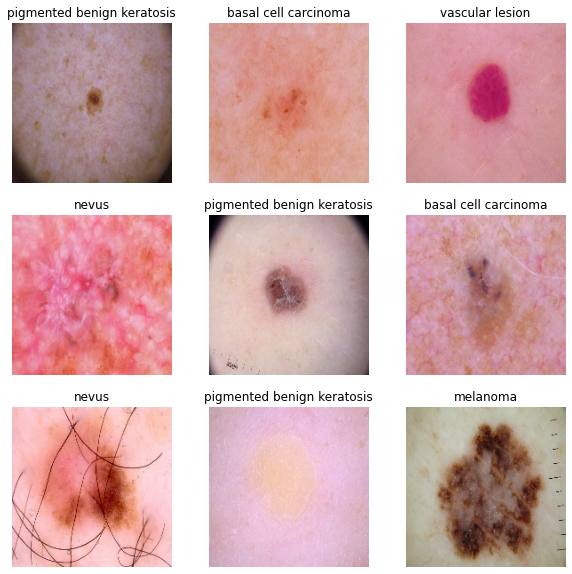

In [12]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
dataset = tf.data.Dataset.range(5)
dataset = dataset.map(lambda x: x**2)
dataset = dataset.cache()
# The first time reading through the data will generate the data using
# `range` and `map`.
print(list(dataset.as_numpy_iterator()))

# Subsequent iterations read from the cache.
print(list(dataset.as_numpy_iterator()))

[0, 1, 4, 9, 16]
[0, 1, 4, 9, 16]


In [14]:
dataset = tf.data.Dataset.range(3)
dataset = dataset.prefetch(2)
list(dataset.as_numpy_iterator())

[0, 1, 2]

In [15]:
# using cache() and prefetch function to optimise the CPU processing.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here
num_classes = 9

# https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling
# Normalizing RGB values
# Padding is kept as same as the information at the edge needs to be retained.

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16,3, padding = 'same', activation = 'relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
                    layers.MaxPool2D(), 
                    layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
                    layers.MaxPool2D(),
                    layers.Flatten(),
                    layers.Dense(256, activation='relu'),
                    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
# https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function
# https://stackoverflow.com/questions/57253841/from-logits-true-and-from-logits-false-get-different-training-result-for-tf-loss
# Since from_logits is set to true, TF is aware that the outputs are not normalized . Now no softmax is required in the output layer.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 78ms/step - loss: 1.9401 - accuracy: 0.2634 - val_loss: 1.8214 - val_accuracy: 0.3065
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6135 - accuracy: 0.4269 - val_loss: 1.4766 - val_accuracy: 0.5101
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4163 - accuracy: 0.5050 - val_loss: 1.5614 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3532 - accuracy: 0.5234 - val_loss: 1.4302 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.2477 - accuracy: 0.5525 - val_loss: 1.3544 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.1577 - accuracy: 0.5831 - val_loss: 1.3973 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.0459 - accuracy: 0.6323 - val_loss: 1.5263 - val_accuracy: 0.5235
Epoch 8/20
5

### Visualizing training results

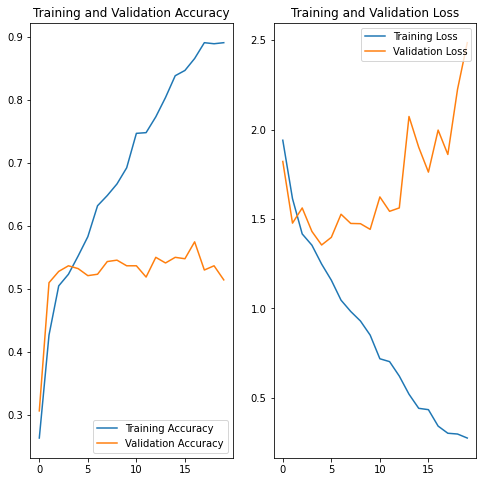

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
- Its clear from the above graph that the difference in accuracy and loss for validation and test dataset is huge, indicating that the model is overfitting.
- It may be the case that the training data at hand is not sufficient to generalize the model. In this case data augmentation should help improve the score further.

### Data Augmentation

In [21]:

# Since images can different greately based on the orientation,contrast , translation and zoom. Lets use these as the augmentation parameters 
# Suppress warnings due to keras bug. https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting

tf.get_logger().setLevel('ERROR')

data_aug = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical', input_shape= (img_height, img_width, 3)),
     layers.experimental.preprocessing.RandomContrast([0.8, 1.0]),
     layers.experimental.preprocessing.RandomZoom(0.2),
     layers.experimental.preprocessing.RandomTranslation(height_factor=(0.2), width_factor=(0.2), fill_mode='reflect')
                              
])

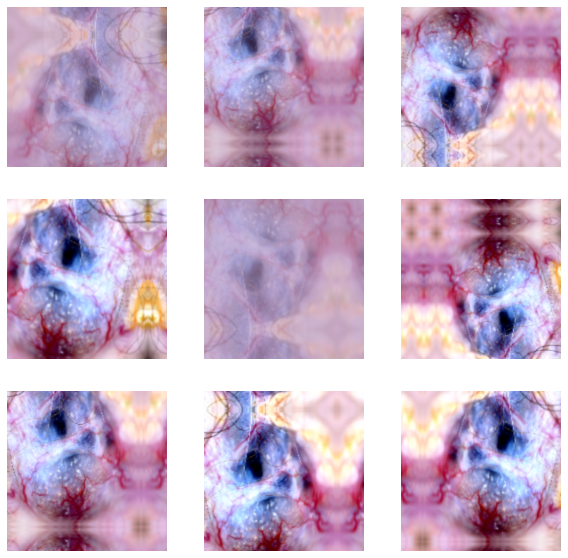

In [22]:
# visualize how your augmentation strategy works 
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    aug_img = data_aug(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(aug_img[0].numpy().astype('uint8'))
    plt.axis("off")


### Create the model, compile and train the model


In [23]:
## Now lets add data augmentation to the model. Also lets add dropout to futher generalize the model and reduce overfitting


model = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16,3, padding = 'same', activation = 'relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
                    layers.MaxPool2D(), 
                    layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
                    layers.MaxPool2D(),
                    layers.Dropout(0.20),
                    layers.Flatten(),
                    layers.Dense(256, activation='relu'),
                    layers.Dropout(0.20),
                    layers.Dense(num_classes)
])


### Compiling the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 17s 248ms/step - loss: 2.1854 - accuracy: 0.2165 - val_loss: 1.9666 - val_accuracy: 0.3087
Epoch 2/20
56/56 [==============================] - 14s 245ms/step - loss: 1.8670 - accuracy: 0.3008 - val_loss: 1.7787 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 14s 245ms/step - loss: 1.7198 - accuracy: 0.3717 - val_loss: 1.8814 - val_accuracy: 0.2640
Epoch 4/20
56/56 [==============================] - 15s 273ms/step - loss: 1.6378 - accuracy: 0.4202 - val_loss: 1.5794 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 14s 246ms/step - loss: 1.5899 - accuracy: 0.4319 - val_loss: 1.5322 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 14s 244ms/step - loss: 1.5543 - accuracy: 0.4475 - val_loss: 1.5263 - val_accuracy: 0.4631
Epoch 7/20
56/56 [==============================] - 14s 245ms/step - loss: 1.4823 - accuracy: 0.4754 - val_loss: 1.4449 - val_accuracy: 0.4877

### Visualizing the results

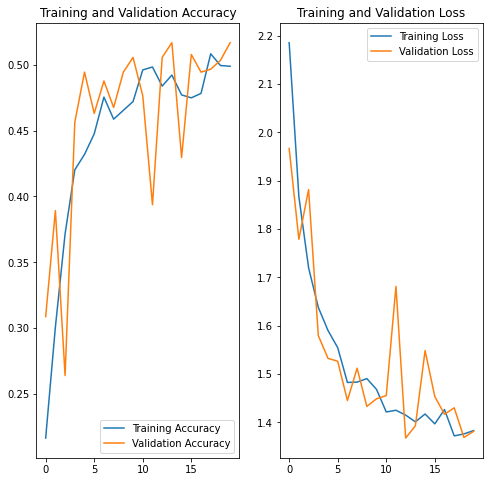

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
- Looking at the above graph its clear that the augmentation did not help and the model seems to be underfitting now as both the train and validation accuracy has dropped significantly.
- Perhaphs there is class imbalance in the training data which needs to be accounted for while augmenting data.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


#### Findings
- Its clear from above that there is class imbalance
- seborrheic keratosis seems to have least number of samples
- pigmented benign keratosis seems to dominate the data in terms proportionate number of samples


In [28]:
# Creating a list of the folder names of each image using its path. 
path_l = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
type_of_image_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, "*", "*.jpg")) ]
type_of_image_list

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [29]:
# Creating a dataset with the image path and its folder name as columns
df_dict = dict(zip(path_l, type_of_image_list))
original_df = pd.DataFrame(list(df_dict.items()), columns= ['Path', 'Label'])

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F13A8C72A90>: 100%|██████████| 1000/1000 [00:42<00:00, 23.52 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F13A8C35820>: 100%|██████████| 1000/1000 [00:34<00:00, 28.79 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F13A8C58100>: 100%|██████████| 1000/1000 [00:35<00:00, 27.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F13A8C99100>: 100%|██████████| 1000/1000 [02:59<00:00,  5.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F13A8BF9AC0>: 100%|██████████| 1000/1000 [02:43<00:00,  6.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1424CB9F10>: 100%|██████████| 1000/1000 [00:32<00:00, 30.59 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1410337BE0>: 100%|██████████| 1000/1000 [01:22<00:00, 12.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F13A8BD42E0>: 100%|██████████| 1000/1000 [00:33<00:00, 29.63 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F13BC3C7E50>: 100%|██████████| 1000/1000 [00:34<00:00, 29.22 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027708.jpg_de5493d7-0079-4ea8-a819-c1f0346fe805.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029533.jpg_4e64574f-7780-4cc1-9832-17e862ca204d.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031918.jpg_85686e33-33c0-45f6-bca2-9e826e253cc7.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030602.jpg_430d64f7-a229-418c-b4a9-863a4b658c89.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030803.jpg_c57c8192-3ece-41e5-887a-1e42afbf8ab6.jpg',
 'Skin cancer ISIC The Interna

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [39]:
augmented_data_dir = data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [41]:
# Lets also add batch normalization,dropout and l2 regularization to generalize the model.
from tensorflow.keras.regularizers import l2
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16,3, padding = 'same', activation = 'relu'),
                    layers.BatchNormalization(),
                    layers.Activation('relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(32,3, padding = 'same', activation = 'relu'),
                    layers.BatchNormalization(),
                    layers.Activation('relu'),
                    layers.MaxPool2D(),
                    layers.Conv2D(64,3, padding = 'same', activation = 'relu'),
                    layers.BatchNormalization(),
                    layers.Activation('relu'),
                    layers.MaxPool2D(),
                    layers.Dropout(0.20),
                    layers.Flatten(),
                    layers.Dense(512, activation='relu',kernel_regularizer=l2(0.01)),
                    layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01)),
                    layers.Dropout(0.20),
                    layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [43]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 41s 140ms/step - loss: 6.2013 - accuracy: 0.3726 - val_loss: 3.5971 - val_accuracy: 0.2305
Epoch 2/30
281/281 [==============================] - 38s 134ms/step - loss: 2.3966 - accuracy: 0.6001 - val_loss: 2.6299 - val_accuracy: 0.4922
Epoch 3/30
281/281 [==============================] - 38s 134ms/step - loss: 1.9607 - accuracy: 0.7025 - val_loss: 1.9907 - val_accuracy: 0.6582
Epoch 4/30
281/281 [==============================] - 38s 134ms/step - loss: 1.7467 - accuracy: 0.7400 - val_loss: 2.0926 - val_accuracy: 0.6057
Epoch 5/30
281/281 [==============================] - 38s 134ms/step - loss: 1.5358 - accuracy: 0.7931 - val_loss: 1.5905 - val_accuracy: 0.7557
Epoch 6/30
281/281 [==============================] - 40s 141ms/step - loss: 1.4333 - accuracy: 0.8153 - val_loss: 1.8023 - val_accuracy: 0.6778
Epoch 7/30
281/281 [==============================] - 38s 135ms/step - loss: 1.2989 - accuracy: 0.8324 - val_loss: 1.4821 - val_ac

#### **Todo:**  Visualize the model results

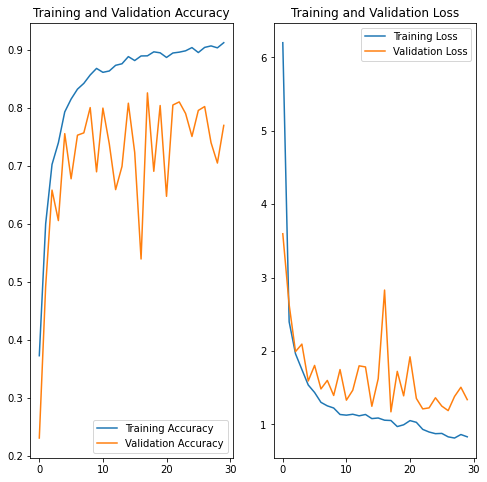

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Findings
- Looking at the above graph its clear that the augmentation to rebalance the classes works a lot better.
- Using the augumented data with rebalanced classes, batch normalization and regularization we finally get a model with is performing well on both training and validation set.
- We got rid of both underfitting and overfitting.
- This model can be further improved by hyperparameter tuning.